In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # graphics
plt.style.use("ggplot")
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

## Data Loading

In [2]:
chunk_size = 150000
chunk_segments = 10
chunk_metadata = 4
num_chunks = 2000

# chunks = np.zeros(shape=(num_chunks,chunk_size))
chunk_mds = np.zeros(shape=(num_chunks,chunk_segments,chunk_metadata))
ttfs = np.zeros(shape=(num_chunks,))
for (i, chunk) in enumerate(pd.read_csv("/kaggle/input/LANL-Earthquake-Prediction/train.csv", chunksize=chunk_size, header=0)):        
    if i == num_chunks:
        break
        
    # processing segments in chunk
    for (j, segment) in enumerate(np.array_split(chunk, chunk_segments)):
        ac_seg_data = segment['acoustic_data']
        chunk_mds[i,j] = [
            np.mean(ac_seg_data),
            np.std(ac_seg_data),
            np.min(ac_seg_data),
            np.max(ac_seg_data)
        ]
    
    # finding final time-to-failure of chunk
    ttfs[i] = chunk['time_to_failure'].iat[-1]
    
    '''
    print(i)
    print(chunk)
    print(np.mean(chunk['acoustic_data']))
    print(np.std(chunk['acoustic_data']))
    print(chunk['acoustic_data'].iat[-1])
    print("")
    '''

## Data Exploration and Visualization

Text(0.5, 0.98, 'Segment Statistics, Chunk 10')

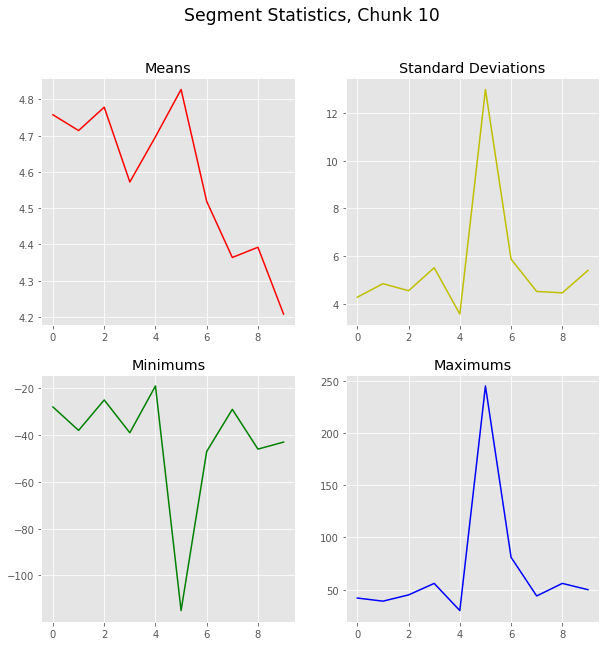

In [3]:
chunk_num = 10

seg_means = chunk_mds[chunk_num,:,0]
seg_stds = chunk_mds[chunk_num,:,1]
seg_mins = chunk_mds[chunk_num,:,2]
seg_maxs = chunk_mds[chunk_num,:,3]

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes[0,0].set_title('Means')
axes[0,0].plot(seg_means, 'r')
axes[0,1].set_title('Standard Deviations')
axes[0,1].plot(seg_stds, 'y')
axes[1,0].set_title('Minimums')
axes[1,0].plot(seg_mins, 'g')
axes[1,1].set_title('Maximums')
axes[1,1].plot(seg_maxs, 'b')
plt.suptitle("Segment Statistics, Chunk " + str(chunk_num), size="xx-large")

# plt.savefig("seg-stats.png")

(array([  9.,  63., 199., 374., 455., 432., 280., 126.,  55.,   7.]),
 array([3.79802   , 3.95741733, 4.11681467, 4.276212  , 4.43560933,
        4.59500667, 4.754404  , 4.91380133, 5.07319867, 5.232596  ,
        5.39199333]),
 <BarContainer object of 10 artists>)

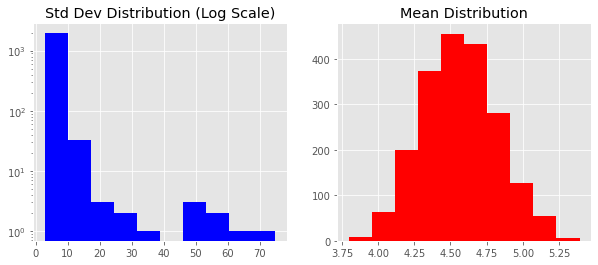

In [4]:
min_chunk = 0
max_chunk = 2000
chunk_stds_full = chunk_mds[min_chunk:max_chunk,:,1]
chunk_stds = np.mean(chunk_stds_full, axis=1)
chunk_means_full = chunk_mds[min_chunk:max_chunk,:,0]
chunk_means = np.mean(chunk_means_full, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].set_title('Std Dev Distribution (Log Scale)')
axes[0].set_yscale('log')
axes[0].hist(chunk_stds, color="b")
# axes[0].bar(np.arange(min_chunk,max_chunk), chunk_stds, color="b")
axes[1].set_title('Mean Distribution')
axes[1].hist(chunk_means, color="r")
# axes[1].bar(np.arange(min_chunk,max_chunk), chunk_means, color="r")

# plt.savefig("stat-dists.png")

Text(0.5, 1.0, 'Time to Failure Distribution')

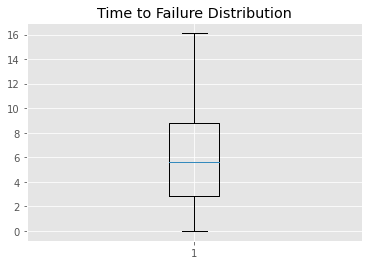

In [5]:
plt.boxplot(ttfs)
plt.title('Time to Failure Distribution')

# plt.savefig("ttf-dist.png")

## Train/Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(chunk_mds, ttfs, test_size=0.2, random_state=0)

## Constructing the Model

In [7]:
# Importing neural network libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import SGD, Adam

In [8]:
# Creating Keras layers, building model
quake_model = None

layers = [
    Flatten(input_shape=(chunk_segments,chunk_metadata)),
    Dense(units=30, activation="relu"),
    Dense(units=30, activation="relu"),
    Dropout(rate=0.15),
    Dense(units=20, activation="relu"),
    Dense(units=10, activation="relu"),
    Dense(units=3, activation="relu"),
    Dense(name="output", units=1, activation="relu")
]

quake_model = Sequential(layers)
# optimizer = SGD(learning_rate=1e-7)
optimizer = Adam(learning_rate=5e-5)
quake_model.compile(optimizer, loss="mae", metrics=["mae", "mse"])

total_epochs = 0

2022-11-01 17:26:16.436133: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Training the Model

In [9]:
# Training model on data
n_epochs = 1000
history = quake_model.fit(X_train, y_train, batch_size=125, epochs=n_epochs, initial_epoch=total_epochs)

total_epochs = total_epochs + n_epochs

2022-11-01 17:26:16.703355: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
13/13 [==============================] - 1s 6ms/step - loss: 6.0345 - mae: 6.0345 - mse: 51.8051
Epoch 2/1000
13/13 [==============================] - 0s 5ms/step - loss: 6.0164 - mae: 6.0164 - mse: 51.7426
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 6.0422 - mae: 6.0422 - mse: 52.6870
Epoch 4/1000
13/13 [==============================] - 0s 5ms/step - loss: 6.0063 - mae: 6.0063 - mse: 51.2161
Epoch 5/1000
13/13 [==============================] - 0s 5ms/step - loss: 5.9403 - mae: 5.9403 - mse: 50.8044
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 5.9640 - mae: 5.9640 - mse: 51.6290
Epoch 7/1000
13/13 [==============================] - 0s 5ms/step - loss: 5.9488 - mae: 5.9488 - mse: 52.9065
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 5.8834 - mae: 5.8834 - mse: 49.9001
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 5.8963 - mae: 5.8963 - mse: 52.3006
Epoch 10/1

Text(0, 0.5, 'Loss (MSE)')

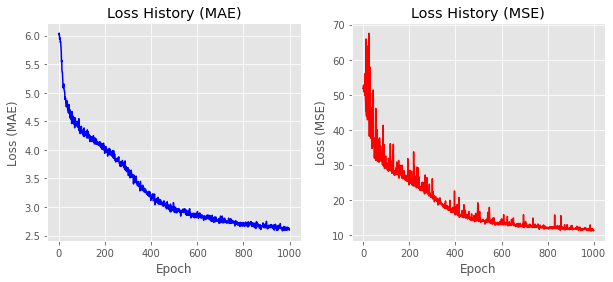

In [10]:
# Seeing how our loss changed throughout training
figure, axes = plt.subplots(1, 2, figsize=(10,4))

axes[0].plot(history.history['mae'], color='b')
axes[0].set_title('Loss History (MAE)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MAE)')
axes[1].plot(history.history['mse'], color='r')
axes[1].set_title('Loss History (MSE)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (MSE)')

# plt.savefig("loss-history.png")

In [11]:
# Evaluating the model
quake_model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 2.7721 - mae: 2.7721 - mse: 12.3179


[2.7721102237701416, 2.7721102237701416, 12.317878723144531]